In [1]:
import pandas as pd
import numpy as np
import warnings
import mlflow
import mlflow.sklearn
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helper_functions import *

In [3]:
nb_variables = {'train_amount': 0.7, 'shift': -1}

In [4]:
x_train = pd.read_csv('Data/x_train.csv', index_col = 0)
x_test = pd.read_csv('Data/x_test.csv', index_col = 0)

y_train = pd.read_csv('Data/y_train.csv', index_col = 0)
y_test = pd.read_csv('Data/y_test.csv', index_col = 0)

In [5]:
x = pd.concat([x_train, x_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)

df = pd.concat([x, y], axis = 1)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)

In [6]:
new_df = n_step_shift(df, nb_variables['shift'])

In [7]:
train_amount = nb_variables['train_amount']
cutoff = int(train_amount * len(df))
shift = np.abs(nb_variables['shift'])

x = new_df.drop(f'total_cases_tp{shift}', axis = 1)
y = new_df[f'total_cases_tp{shift}']

x_train = x.iloc[:cutoff, :]
x_test = x.iloc[cutoff:, :]

y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

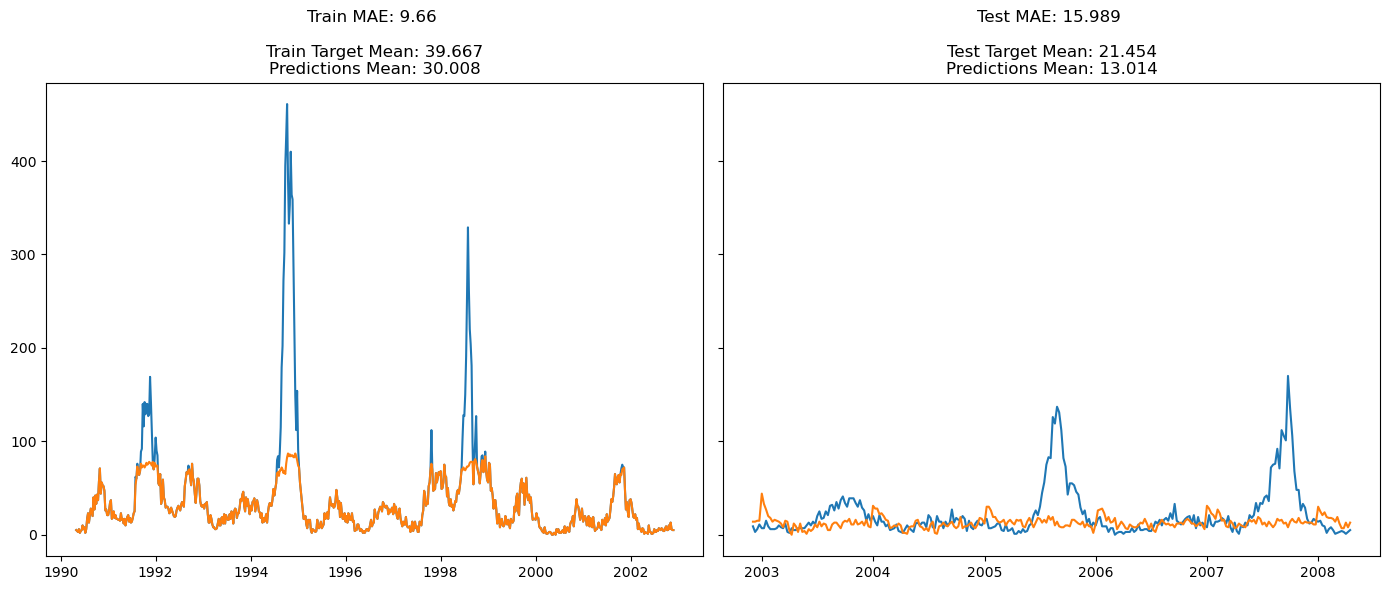

In [10]:
model_1 = XGBRegressor(n_estimators = 800, booster = 'gbtree', subsample = 1, tree_method = 'exact',
                       objective = 'reg:absoluteerror', max_depth = 8, learning_rate = 0.1, 
                       nthread = 4, gamma = 0, random_state = 50)
# Fit model
model_1.fit(x_train, y_train)

# Get MAE on Train and Test sets
train_preds = model_1.predict(x_train)
train_preds[train_preds < 0] = 0
train_preds = np.round(train_preds).astype('int32')

test_preds = model_1.predict(x_test)
test_preds[test_preds < 0] = 0
test_preds = np.round(test_preds).astype('int32')

train_mae = np.round(np.mean(np.abs(train_preds - y_train.values)), 3)
test_mae = np.round(np.mean(np.abs(test_preds - y_test.values)), 3)
# # --------------- Logging --------------- #
# mlflow.log_param('Window', nb_variables['window'])
# mlflow.log_param('Shift', nb_variables['shift'])
# mlflow.log_param('Train amount', train_amount)
# mlflow.log_param('Drop Threshold', nb_variables['drop_threshold'])
# mlflow.log_param('Booster', model_1.booster)
# mlflow.log_param('Number of Estimators', model_1.n_estimators)
# mlflow.log_param('Max Depth', model_1.max_depth)
# mlflow.log_param('Gamma', model_1.gamma)
# mlflow.log_param('Learning Rate', model_1.learning_rate)

# mlflow.log_metric('Train MAE', train_mae)
# mlflow.log_metric('Test MAE', test_mae)

# mlflow.sklearn.log_model(model_1, 'XGBoostRegressor')
# # --------------- Logging --------------- #

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (14, 6))

train_title = (f'Train MAE: {train_mae} \n', 
               f'Train Target Mean: {np.round(y_train.values.mean(), 3)}', 
               f'Predictions Mean: {np.round(np.mean(train_preds), 3)}')
axs[0].set_title('\n'.join(train_title))
axs[0].plot(y_train)
axs[0].plot(y_train.index, train_preds)

test_title = (f'Test MAE: {test_mae} \n', 
              f'Test Target Mean: {np.round(y_test.values.mean(), 3)}', 
              f'Predictions Mean: {np.round(np.mean(test_preds), 3)}')
axs[1].set_title('\n'.join(test_title))
axs[1].plot(y_test)
axs[1].plot(y_test.index, test_preds)

# plt.savefig('predictions_viz.png')

# mlflow.log_artifact('predictions_viz.png')
plt.tight_layout()
plt.show()

In [11]:
pickle.dump(model_1, open('model.pkl', 'wb'))